In [69]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcdefaults()
import quandl
import pandas as pd
import numpy as np
import functools
import statistics
import math
import os
from datetime import datetime
import random
import scipy as sp
import warnings
import gzip
from collections import Counter
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
pd.options.mode.chained_assignment = None

# Arjun Kilaru
# Accumulation Algorithms (ETH-USD)

## 1.1 Loading the Data

### Data Considerations

Here I am loading all of the data for trades, even though I plan to only use the ETH-USD trades. According to the TA office horus, the book data is unnecessary for implementing the algorithm, so the data I will use will be primarily the trades in ETH-USD for all three available years.

In [3]:
book_btcusd = pd.read_csv('book_narrow_BTC-USD_2023.delim', delim_whitespace = True)
book_ethbtc = pd.read_csv('book_narrow_ETH-BTC_2023.delim', delim_whitespace = True)
book_ethusd = pd.read_csv('book_narrow_ETH-USD_2023.delim', delim_whitespace = True)
trades_btcusd = pd.read_csv('trades_narrow_BTC-USD_2023.delim', delim_whitespace = True)
trades_ethbtc = pd.read_csv('trades_narrow_ETH-BTC_2023.delim', delim_whitespace = True)
trades_ethusd = pd.read_csv('trades_narrow_ETH-USD_2023.delim', delim_whitespace = True)

In [52]:
trades_ethusd

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521275236165000,1674521271071902000,1629670000,11815210,-1
1,1674521275287511000,1674521271398509000,1629770000,92158690,1
2,1674521275288004000,1674521271398509000,1629780000,712594890,2
3,1674521275288470000,1674521271398509000,1629790000,1016994240,2
4,1674521275330683000,1674521271578052000,1629770000,92150000,1
...,...,...,...,...,...
377180,1674658830284683000,1674658830318708000,1533330000,2560936460,1
377181,1674658830285405000,1674658830318708000,1533340000,5056896150,3
377182,1674658830287086000,1674658830319185000,1533310000,2095786600,1
377183,1674658830299074000,1674658830330265000,1533310000,1181857040,2


## 1.2 Creating the Time-Blocks 

The assignment page mentioned that we should be taking the price / volume of the worst performing trade if they are in a series of quick succession. As such, I have written below a function create_blocks, which takes in a dataframe of trades and a desired side and groups trades which have all cumulatively occured during a span of 0.1s together. The time of that trade along with the lowest price among the group and that trade's respective quanttiy is the one reported. All of the trades within the block are within 0.1s of their neighboring trade; once the 0.1s threshold has been crossed a new block will be created.

In [21]:
def create_blocks(df, side):
    data = pd.DataFrame()
    times = []
    prices = []
    sizes = []
    temp_times = []
    temp_prices = []
    temp_sizes = []
    block_sizes = []
    for i in range(len(df)):
        if df.loc[i, 'Side'] > 0 and side == 'buy':
            continue
        if df.loc[i,'Side'] < 0 and side == 'sell':
            continue
        temp_time = df.loc[i,'timestamp_utc_nanoseconds']
        temp_price = df.loc[i,'PriceMillionths']
        temp_size = df.loc[i,'SizeBillionths']
        if not temp_times:
            temp_times.append(temp_time)
            temp_prices.append(temp_price)
            temp_sizes.append(temp_size)
        if temp_time > temp_times[len(temp_times)-1] + 100000000:
            times.append(temp_times[temp_prices.index(min(temp_prices))])
            prices.append(min(temp_prices)/1000000)
            sizes.append(temp_sizes[temp_prices.index(min(temp_prices))]/1000000000)
            block_sizes.append(len(temp_times))
            temp_times = [temp_time]
            temp_prices = [temp_price]
            temp_sizes = [temp_size]
        elif temp_time < temp_times[len(temp_times)-1] + 100000000:
            temp_times.append(temp_time)
            temp_prices.append(temp_price)
            temp_sizes.append(temp_size)
    data['Time'] = times
    data['Prices'] = prices
    data['Sizes'] = sizes
    data['Block Sizes'] = block_sizes
    return data


### 1.2.1 Time Block Analysis
So we see that over 75% of the 55,065 blocks created have less than 4 total trades in them. There is one outlier with 522 consolidated trades. 

In [24]:
create_blocks(trades_ethusd, 'buy')['Block Sizes'].describe()

count    55065.000000
mean         3.093998
std          4.371213
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        522.000000
Name: Block Sizes, dtype: float64

## 2.1 Writing the Accumulation Algorithm 

Our VWAP funciton will take in a dataframe, a quantity, a time, and a participation rate. It will cycle through the trades and assume the participation rate in them, accumulating the position over time. When the entire trade is executed, the function will print the time taken as well as the dataframe of trades, which logs positions over time and the prices and quantites each trade executes at. If the trade does not occur within **fifteen minutes**, the function will stop and return the amount that was traded within those fifteen minutes along with the corresponding dataframe. I did this to remain in compliance with the assignment instructions of focusing on trades that execute within 15 minutes. The cumulative transaction cost is also recorded across the trades, presented in dollar terms. Furthermore, when the trade is successfully executed, the function will print the total start to end price difference, meaning the difference in the underlying's price from when the trade began to when the trade ended. As noted by the TA, no chunk rate will be considered, we will instead just be using a fraction of the trade volume throughout. 

In [215]:
def vwap (dataframe, q, ts, p, hide_print = True):
    output = pd.DataFrame()
    trade_prices = []
    trade_quantities = []
    trade_times = []
    transaction_costs = []
    traded = 0
    trans_time = 0
    traded_amt = []
    if q > 0:
        df = create_blocks(dataframe, 'buy')
    else:
        q = q*-1
        df = create_blocks(dataframe, 'sell')
    for i in range(len(df)):
        if df.iloc[i,0] < ts:
            continue
        size = p*df.loc[i,'Sizes']
        traded = traded + size
        traded_amt.append(traded)
        time = df.loc[i,'Time']
        price = df.loc[i,'Prices']
        if traded + size > q:
            trade_quantities.append(q-traded)
            trade_prices.append(price)
            trade_times.append(time)
            transaction_costs.append(0.5*0.01*(q-traded)*price)
            break
        trade_times.append(time)
        trade_quantities.append(size)
        trade_prices.append(price)
        transaction_costs.append(0.5*0.01*size*price)
        if time - trade_times[0] > 1000000000*60*15:
            output['times'] = trade_times
            output['prices'] = trade_prices
            output['quantities'] = trade_quantities
            if not hide_print:
                print("Accumulation failed: Fifteen Minute Limit Reached")
                print("Amount traded: " + str(output['quantities'].cumsum().tolist()[-1]) + " out of " + str(q))
            output['cumulative transaction cost'] = np.cumsum(transaction_costs)
            return (output, False)
        
    output['times'] = trade_times
    output['prices'] = trade_prices
    output['traded'] = traded_amt
    output['quantities'] = trade_quantities
    output['cumulative transaction cost'] = np.cumsum(transaction_costs)
    length = (trade_times[-1] - trade_times[0])/(1000000000*60)
    if not hide_print:
        print("Passed. Total trade time: " + str(length) + " minutes")
    return output

In [290]:
vvs = vwap(trades_ethusd, 30, 1674521276188059000+1000000000*2700, 0.05, False)

Accumulation failed: Fifteen Minute Limit Reached
Amount traded: 23.23780106299999 out of 30


In [303]:
vwap(trades_ethusd, -9, 1674521276188059000+1000000000*2700, 0.05, False)

Passed. Total trade time: 11.085556483333333 minutes


,times,prices,traded,quantities,cumulative transaction cost
0,1674524877377162000,1632.67,0.000228,0.000228,0.001865
1,1674524878122892000,1632.64,0.000411,0.000183,0.003357
2,1674524878757831000,1632.59,0.003511,0.003100,0.028658
3,1674524879156577000,1632.60,0.005816,0.002305,0.047477
4,1674524880879277000,1632.58,0.006091,0.000274,0.049717
...,...,...,...,...,...
1049,1674525541800721000,1638.02,8.446741,0.019711,69.070130
1050,1674525541946995000,1638.03,8.454204,0.007463,69.131254
1051,1674525542065475000,1638.02,8.458423,0.004220,69.165813
1052,1674525542187133000,1638.02,8.469703,0.011280,69.258193


In [107]:
vvv['quantities'].cumsum()

0       0.001992
1       0.004141
2       0.005454
3       0.014657
4       0.016482
         ...    
631    10.722540
632    10.809076
633    10.839729
634    10.839795
635    10.839876
Name: quantities, Length: 636, dtype: float64

## 2.2 Relevant Graphing Functions

Here are functions to graph the changes in the underlying security's price as the trade executes, as well as the cumulative transaction cost as the trade executes. 
There is also a function to graph the notional over time, to visulize how the function executes as the minutes pass. 

End price differential = 1.2300000000000182


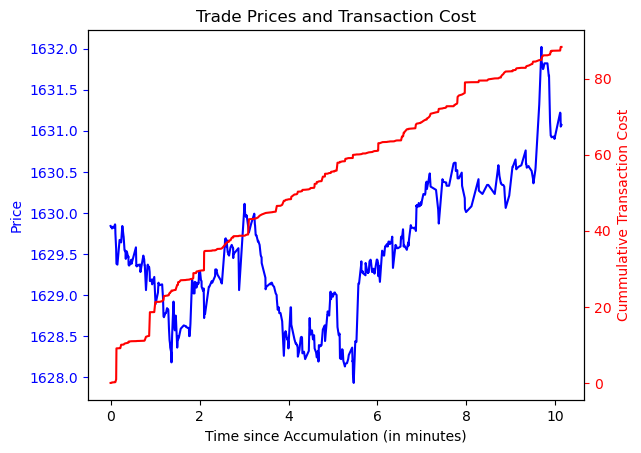

In [166]:
def graph_prices_vwaps(df):
    zerotimes = (df['times'] - df['times'][0])/(1000000000*60)
    graph = pd.DataFrame()
    graph.index = zerotimes
    graph['Prices'] = df['prices'].tolist()
    x = graph.index
    y1 = graph['Prices'].tolist()
    y2 = df['cumulative transaction cost'].tolist()
    fig, ax1 = plt.subplots()
    ax1.plot(x, y1, 'b-')
    ax1.set_xlabel('Time since Accumulation (in minutes)')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params('y', colors='b')

    # Create second y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r-')
    ax2.set_ylabel('Cummulative Transaction Cost', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Trade Prices and Transaction Cost")
    #plot = graph.plot()
    #plot.set_xlabel("Time (in minutes) since accumulation")
    print('End price differential = ' + str(y1[-1] - y1[0]))
    return 

graph_prices_vwaps(vvv)

In [200]:
def get_times_and_prices(df):
    prices = df['prices'].tolist()
    times = df['times'].tolist()
    mins = (times[-1] - times[0])/(1000000000*60)
    diff = float(prices[-1]) - float(prices[0])
    return (diff, mins)

In [112]:
def graph_notional_time_vwaps(df):
    df['notional'] = df['quantities'] * df['prices']
    df['time_since_seconds'] = (df['times'] - df['times'].tolist()[0])/(1000000000*60)
    fig, ax = plt.subplots()
    x = df['time_since_seconds'].tolist()
    y = df['notional'].tolist()
    ax.plot(x,y)
    ax.set_xlabel('Time since Accumulation (in minutes)')
    ax.set_ylabel('Trade Notional')
    plt.title("Trade Notional Over Time (not Cumulative)")


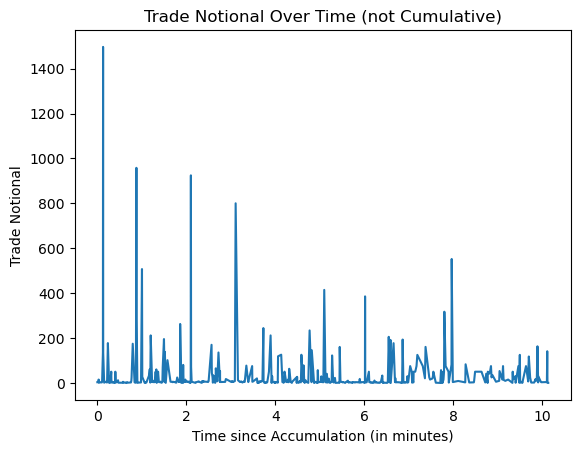

In [117]:
graph_notional_time_vwaps(vvv)

## 2.3 Generating roughly Independent VWAPS from trades dataframe
Here, we are taking the overall dataframe of trades and picking twentry random times. First we will write a helper function to make sure the twenty times we selected are random. Then, we will generate five different, independent VWAP times to analyze. We will make sure that all of the times selected are at least 10 minutes apart from each other.

In [245]:
def get_independent(timeslist):
    switch = False
    counter = 0
    random.shuffle(timeslist)
    lst = timeslist[0:30]
    return lst
    while not switch:
        random.shuffle(timeslist)
        lst = timeslist[0:30]
        for i in range(len(lst)-1):
            if abs(lst[i] - lst[i + 1]) > 1000000000*60*10:
                counter +=1
        if counter > 10:
            switch = True
    return lst

In [ ]:
def get_independent_vwaps(df, q, p):
    vwaps = []
    lst = get_independent(df['timestamp_utc_nanoseconds'].tolist())
    i = -1
    while len(vwaps) < 5 :
        i+=1
        vp = vwap(df, q, lst[i], 0.05, hide_print = True)
        if not isinstance(vp, tuple):
            vwaps.append(vp)
    return vwaps

#get_independent_vwaps(trades_ethusd, 10, 0.05)

## 3.1 Analysis: Ratios and Executions
Now, we will analyze the different ratios and plots among different time periods. For each period, I will first use a p rate of 0.05 and a Q of 10 ethereum. 

In [147]:
trades_ethusd_2022 = pd.read_csv('trades_narrow_ETH-USD_2022.delim', delim_whitespace = True)
trades_ethusd_2021 = pd.read_csv('trades_narrow_ETH-USD_2021.delim', delim_whitespace = True)

In [247]:
vwaps2023 = get_independent_vwaps(trades_ethusd, 10, 0.05)
vwaps2022 = get_independent_vwaps(trades_ethusd_2022, 10, 0.05)
vwaps2021 = get_independent_vwaps(trades_ethusd_2021, 10, 0.05)

### 3.2 Analysis I: Price Differential & Time to Execution

Here, we will analyze how the price differential relates with time to execution for trades across all three years. Ten executed trades will be randomly selected from each of the three years and their price differential and time to execution will be plotted for analysis. This exercise seeks to explore how the potential loss or gain from price changes during accumulation varies both by execution time and by year. It may be found that price changes were especially volatile in one year over another, or it may be found that accumulation finished much faster in one year over another, hinting at insight regarding the underlying tokens.

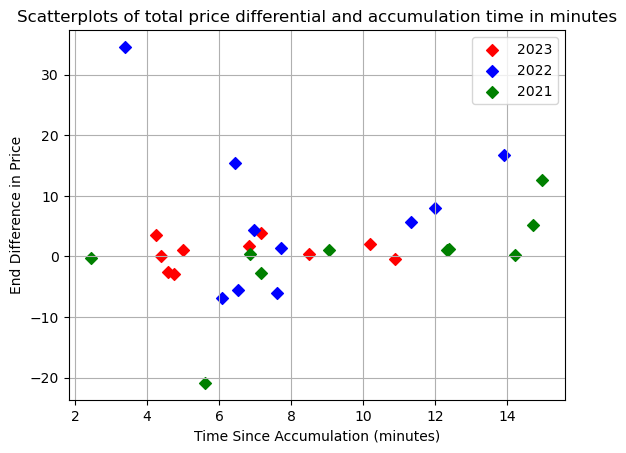

In [251]:
def map_prices(df1, df2, df3):
    prices1, prices2, prices3 = [], [], []
    times1, times2, times3 = [], [], []
    for i in range(10):
        prices1.append(get_times_and_prices(df1[i])[0])
        prices2.append(get_times_and_prices(df2[i])[0])
        prices3.append(get_times_and_prices(df3[i])[0])
        times1.append(get_times_and_prices(df1[i])[1])
        times2.append(get_times_and_prices(df2[i])[1])
        times3.append(get_times_and_prices(df3[i])[1])      
    fig, ax = plt.subplots()
    ax.scatter(times1, prices1, color='red', label='2023', marker = 'D')
    ax.scatter(times2, prices2, color='blue', label='2022', marker = 'D')
    ax.scatter(times3, prices3, color='green', label='2021', marker = 'D')
    ax.legend()
    plt.title('Scatterplots of total price differential and accumulation time in minutes')
    plt.xlabel("Time Since Accumulation (minutes)")
    plt.ylabel("End Difference in Price")
    ax.grid(True)
    plt.show()
    return(prices1, prices2, prices3, times1, times2, times3)
maps = map_prices(vwaps2023, vwaps2022, vwaps2021)

In [297]:
statistics.mean(maps[3])

6.654689448333333

From this graph, it can be seen that in 2023 only, the price differentials were between a range of positive and negative five. All trades also finished within a span of eleven minutes. On the other hand, in 2022, the price differential was much more varied, with a standard deviation of 12.84 from a mean of 6.75399. In 2021, the mean difference was -0.33 with a standard deviation of 8.37. 2021 had one significant outlier, where the price differential was over -20. from the start of the trade to the end of the trade. In 2022, there was also an outlier where the ending price differential was greater than 30. The mean price differential among the 2023 trades was 0.65 with a standard deviation of 2.259. Clearly, prices were generally more stable in 2023 compared to 2021 and 2022. Historically, that makes sense, as during those years cryptocurrencies including Ethereum were especially volatile. 

Regarding times, all trades seemed to finish relatively uniformly over the 15 minute period. Trades in 2023 all finished before the 12-minute mark, which is an indicator that volumes were likely higher in these years compared to other years. Coversely, in 2021, the trades finished on average around 10 minutes after beginning, whereas in 2022, trades finished roughly 8 minutes after beginning. This is compared to the average 6.6 minutes in 2023. These statistics indicate that in 2023, trades were relatively more frequent, which allowed for more opportunities to execute the accumulation algorithm and finish the trade.

### 3.2 Analysis II: Q & p vs. Pass Rate
Here, we will focus once again on the 2023 dataset. Using a benchmark p of 5%, we will now compare different Q value with pass rates. We will run 5 different trades and see what the pass rates are for different Q's. Next, we will explore how different participation rate values lead to different pass rates. This will certainly yield optimal insight on the best p and Q values to set when running our algorithms to ensure that we achieve our desired pass rate. For example, if we desire for our algorithms to finish with 15 minutes, we may need to consider choosing p and Q in a way that will ensure success. 

In [293]:
def pass_rate(df, q, p):
    counter = 0
    lst = get_independent(df['timestamp_utc_nanoseconds'].tolist())
    for i in range (0,10):
        if not isinstance(vwap(df, q, lst[i], p, hide_print = True), tuple):
            counter +=1
    return counter / 10

def plot_rates(df):
    qlist = []
    ratelist = []
    for i in range(5,17):
        qlist.append(i)
        ratelist.append(pass_rate(df,i, 0.05))
    fig, ax = plt.subplots()
    ax.plot(qlist, ratelist)
    plt.title('Pass Rates for Different Q Values')
    plt.xlabel('Q Value')
    plt.ylabel('Pass Rate')
    plt.show()
    return (qlist, ratelist)

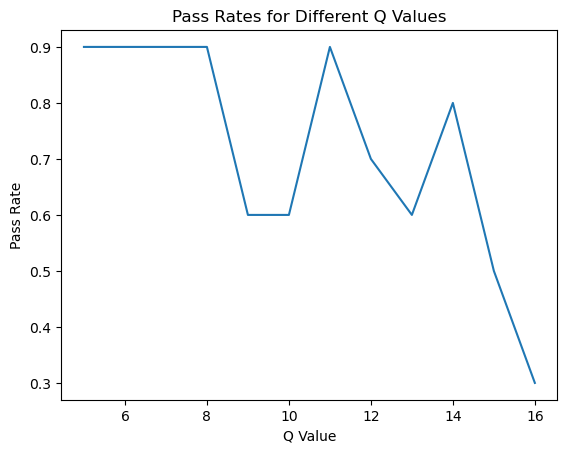

In [294]:
plts2 = plot_rates(trades_ethusd)

This shows that in general, the success rates are still not guaranteed for Q values as low as 5, as in that case only 90% of trades passed. As Q increased, there was a stark decrease, going from 11 onward featured significant drop offs. This indicates that if we want to ensure high pass rates, a Q value of under 11 should be considered. Now let us compare with p values as well. We can overlay multiple graphs to showcase how the pass rates are changed. 

In [287]:
def plot_many_rates(df):
    qlist = []
    plist = [0.01, 0.025, 0.075, 0.1]
    ratelist= [[],[],[],[],[]]
    for i in range(5,17):
        qlist.append(i)
        for j in range(len(plist)):
            ratelist[j].append(pass_rate(df,i,plist[j]))
    fig, ax = plt.subplots()
    ax.plot(qlist, ratelist[0], label = 'p = 0.01')
    ax.plot(qlist, ratelist[1], label = 'p = 0.025')
    ax.plot(qlist, ratelist[2], label = 'p = 0.075')
    ax.plot(qlist, ratelist[3], label = 'p = 0.1')
    ax.legend()
    plt.title('Pass Rates for Different Q and P Values')
    plt.xlabel('Q Value')
    plt.ylabel('Pass Rate')
    plt.show()
    

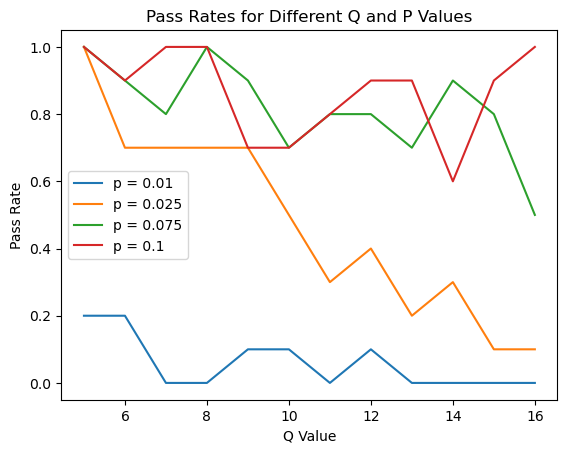

In [295]:
plts = plot_many_rates(trades_ethusd)

As the graph indicates, for lower p values, almost all trades fail to execute within the 15 day allotment. With higher p values, such as 0.1 and 0.075, nearly all trades are executed regardless of the Q value, with at most 80% of trades succeeding. Typically, every trade or at least 70% of trades execute at this rate. As such, we should certainly choose our p values to be around or higher than 0.075 if we want assurance that a majority of our algorithms will pass.

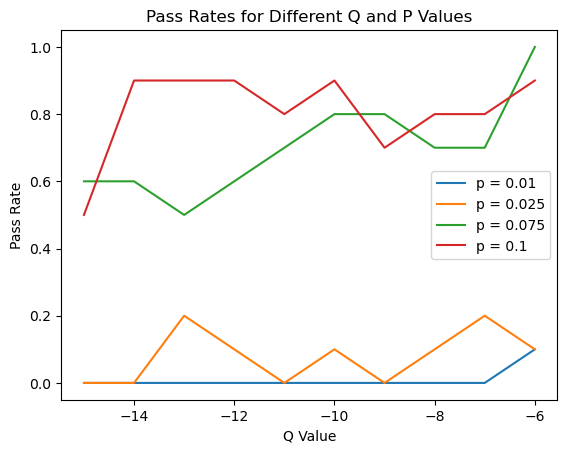

In [314]:
def plot_many_rates2(df):
    qlist = []
    plist = [0.01, 0.025, 0.075, 0.1]
    ratelist= [[],[],[],[],[]]
    for i in range(-15,-5):
        qlist.append(i)
        for j in range(len(plist)):
            ratelist[j].append(pass_rate(df,i,plist[j]))
    fig, ax = plt.subplots()
    ax.plot(qlist, ratelist[0], label = 'p = 0.01')
    ax.plot(qlist, ratelist[1], label = 'p = 0.025')
    ax.plot(qlist, ratelist[2], label = 'p = 0.075')
    ax.plot(qlist, ratelist[3], label = 'p = 0.1')
    ax.legend()
    plt.title('Pass Rates for Different Q and P Values')
    plt.xlabel('Q Value')
    plt.ylabel('Pass Rate')
    plt.show()
    
plot_many_rates2(trades_ethusd)
    

Looking at negative Q (buying vs. selling) values, it is much of the same. Only for the higher p values of 0.1 and 0.075 do the pass rates exceed 50%. For Q values closer to zero, the pass rate is higher across the board, which is expected. In terms of making trades, it is important to consider the notional and participation rates in order to ensure our trades pass within a certain time frame.

### 3.3. Analysis III: Quantity Traded Over Time
It may be interesting to examine the cumulative quantity traded throughout the duration of the trade and observe whether or not the trades follow a uniform ascent. If it is the case that certain trades make up a significant spike in quantity traded, then we may want to shift our algorithms to adjust for this reality, as we may not want to be included as significantly in major trades. For this, we will randomly select 5 trades that executed and plot the cumulative quantity traded over time. We will use a constant p and Q value in this case. 

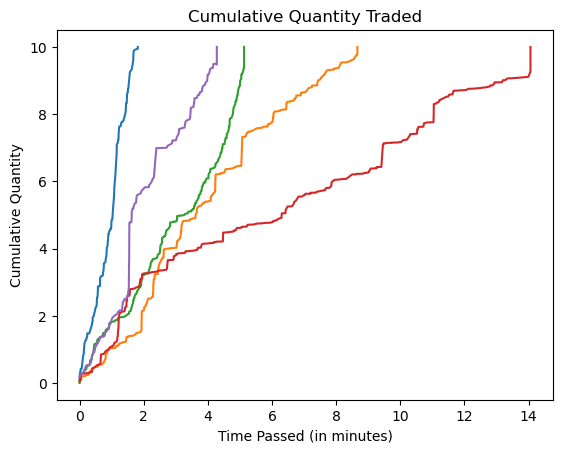

In [312]:
def plot_q_traded(df):
    vwaps = get_independent_vwaps(df, 10, 0.05)
    quantitylist = [[],[],[],[],[]]
    timelist = [[],[],[],[],[]]

    for i in range(5):
        timelist[i] = ((vwaps[i]['times'] - vwaps[i]['times'][0])/(1000000000*60)).tolist()
        quantitylist[i] = vwaps[i]['quantities'].cumsum().tolist()
        quantitylist[i].append(10)
        timelist[i].append(timelist[i][-1])
        
    fig, ax = plt.subplots()
    ax.plot(timelist[0],quantitylist[0])
    ax.plot(timelist[1],quantitylist[1])
    ax.plot(timelist[2],quantitylist[2])
    ax.plot(timelist[3],quantitylist[3])
    ax.plot(timelist[4],quantitylist[4])
    plt.title('Cumulative Quantity Traded')
    plt.xlabel('Time Passed (in minutes)')
    plt.ylabel('Cumulative Quantity')
    plt.show()
    return (quantitylist, timelist)
pt = plot_q_traded(trades_ethusd)

As the graph showcases, each accumulation trade completes in a roughly uniform time, with there being no major nonlinear patterns, jumps or discrepancies. There is not a clear nonlinear trend in these graphs. Most are finishing in a uniform pattern, soaAs traders, this is an indication that our algorithms are running evenly across the time to completion. There does not appear to be need to shift our algorithms to adjust for potential spikes or jumps in the cumulative position traded. 

## Conclusion

Overall, we were able to draft accumulation algorithms for ETH-USD trades that executed in 15 minutes. In addition, we were able to map the transaction costs accrued by engaging in these trades as well as the overall price differential from when the trade began and ended. We were also able to graph how the notional over time changed as the trade progressed. 

Moving on to ratios, we studied the changes in price differential and time to execution in three years of trade data, which revealed potential underlying patterns of price volatility and trade volume that can be further studied. We also looked at how pass rates differ for Q and P values, which is important to consider in the creation of accumulation strategies, as traders may want to ensure a specific pass rate for a set time frame (in our case, we used fifteen minutes) by choosing certain parameters. Lastly, we plotted how trade quantites change throughout the time of the trade and concluded that there were no noticeable jumps or nonlinear patterns, which indicates that the trades execute in a rather uniform fashion, which provides important information to traders on the status of their positions. Ultimately, we assessed and contrasted the accumulation opportunities available in cryptotoken markets in 2021, 2022 and 2023, and concentrated on transactions that finish in 1-15 minutes. I considered metrics such as price differential and accumulation time by year, pass rates for Q and participation rate values, and quantity traded over time. Thank you.